# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format

/home/user/.local/share/virtualenvs/labo-a041pJnc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
def clase_renta(renta,max = 35000, big = 18000,low=1000):
    if renta > max:
        return 3
    elif renta > big:
        return 2
    elif renta > low:
        return 1
    else:
        return 0

def agrupar_edades(edad):
    if edad <= 25:
        return 'hasta 25'
    elif edad <= 35:
        return '26 a 35'
    elif edad <= 45:
        return '36 a 45'
    elif edad <= 55:
        return '46 a 55'
    elif edad <= 65:
        return '56 a 65'
    else:
        return 'mayor de 65'

def edad_split(edad):
    if edad <= 45:
        return '18-45'
    else:
        return '45+'

In [3]:
df_train = pd.read_csv("./../../../datasets/exp_4_TRAINING_STRATEGY_miranda_15_dataset_training.csv.gz")



In [4]:
df_train_pr = df_train[['cprestamos_personales','cprestamos_prendarios','cprestamos_hipotecarios','cplazo_fijo','cinversion1','cinversion2','cseguro_vida','cseguro_auto','cseguro_vivienda','cseguro_accidentes_personales','ccaja_seguridad']]

In [5]:
df_train['productos_premium'] = df_train_pr.apply(lambda x: x['cprestamos_personales']+x['cprestamos_prendarios']+x['cprestamos_hipotecarios']+x['cplazo_fijo']+x['cinversion1']+x['cinversion2']+x['cseguro_vida']+x['cseguro_auto']+x['cseguro_vivienda']+x['cseguro_accidentes_personales']+x['ccaja_seguridad'],axis=1)
del df_train_pr

In [6]:
df_train = df_train.drop(['azar_under','azar_sampling','fold_train','fold_test'],axis=1)

In [7]:
#Xtrain = df_train[df_train["foto_mes"] == 202105 ]
#Xtrain = df_train
Xtrain = df_train.query("foto_mes in [202105,202104,202103]")
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [8]:
Xbajas = df_train.query("clase_ternaria != 'CONTINUA'")

In [9]:
Xbajas.groupby('foto_mes').count()

,numero_de_cliente,active_quarter,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,...,vmr_mpagospesos_min8,vmr_mpagospesos_max8,vmr_mpagosdolares_min8,vmr_mpagosdolares_max8,vmr_mconsumototal_min8,vmr_mconsumototal_max8,vmr_mpagominimo_min8,vmr_mpagominimo_max8,fold_validate,productos_premium
foto_mes,,,,,,,,,,,,,,,,,,,,,
202007,172,172,172,172,172,172,172,172,172,172,...,171,171,171,171,171,171,171,171,172,172
202008,142,142,142,142,142,142,142,142,142,142,...,140,140,140,140,140,140,140,140,142,142
202009,127,127,127,127,127,127,127,127,127,127,...,126,126,126,126,126,126,126,126,127,127
202010,160,160,160,160,160,160,160,160,160,160,...,160,160,160,160,160,160,160,160,160,160
202011,180,180,180,180,180,180,180,180,180,180,...,179,179,179,179,179,179,179,179,180,180
202012,217,217,217,217,217,217,217,217,217,217,...,214,214,214,214,214,214,214,214,217,217
202101,253,253,253,253,253,253,253,253,253,253,...,250,250,250,250,250,250,250,250,253,253
202102,284,284,284,284,284,284,284,284,284,284,...,283,283,283,283,283,283,283,283,284,284
202103,327,327,327,327,327,327,327,327,327,327,...,326,326,326,326,326,326,326,326,327,327


Y nos deshacemos del target y limpiamos un poco la memoria.

In [10]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [11]:
# create dataset for lightgbm
#lgb_train = lgb.Dataset(Xtrain[Xtrain.columns.difference(['uso_app_bool', 'edad_split'])], ytrain)
df = Xtrain.copy()
lgb_train = lgb.Dataset(Xtrain[Xtrain.columns.difference(['foto_mes'])], ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
    'random_state':539141
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.731021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Y miramos su importancia de variables

In [12]:
lgb_train.categorical_feature

'auto'

In [13]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
364,mcuentas_saldo,77
165,ccallcenter_transacciones,70
412,mprestamos_personales,70
452,productos_premium,69
347,mcomisiones_mantenimiento,68
...,...,...
369,mextraccion_autoservicio_min8,0
203,cforex_min8,0
204,cforex_sell,0
62,Master_msaldototal_min8,0


In [14]:
# df_train['edad_ag'] = df_train.cliente_edad.apply(agrupar_edades)
# df_train['edad_ag'] = df_train['edad_ag'].astype('category')
# df_train['edad_ag'] = df_train['edad_ag'].cat.reorder_categories(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'])

# df_train['edad_split'] = df_train.cliente_edad.apply(edad_split)
# df_train['renta_clase'] = df_train.mrentabilidad_annual.apply(clase_renta)
# df_train['uso_app_bool'] = df_train.cmobile_app_trx.apply(lambda x: 'sí' if x>=1 else 'no')

In [15]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','foto_mes'])])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [16]:
df['edad_ag'] = df.cliente_edad.apply(agrupar_edades)
df['edad_ag'] = df['edad_ag'].astype('category')
df['edad_ag'] = df['edad_ag'].cat.reorder_categories(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'])

df['edad_split'] = df.cliente_edad.apply(edad_split)
df['renta_clase'] = df.mrentabilidad_annual.apply(clase_renta)
df['uso_app_bool'] = df.cmobile_app_trx.apply(lambda x: 'sí' if x>=1 else 'no')

Xbajas['edad_ag'] = Xbajas.cliente_edad.apply(agrupar_edades)
Xbajas['edad_ag'] = Xbajas['edad_ag'].astype('category')
Xbajas['edad_ag'] = Xbajas['edad_ag'].cat.reorder_categories(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'])

Xbajas['edad_split'] = Xbajas.cliente_edad.apply(edad_split)
Xbajas['renta_clase'] = Xbajas.mrentabilidad_annual.apply(clase_renta)
Xbajas['uso_app_bool'] = Xbajas.cmobile_app_trx.apply(lambda x: 'sí' if x>=1 else 'no')

In [17]:
df = pd.concat([df.reset_index(),ytrain.reset_index()],axis=1).rename(columns={'clase_ternaria':'target'})
del Xtrain, ytrain


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [18]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])].columns)
shap_bajas

,Master_Finiciomora,Master_Finiciomora_max8,Master_Finiciomora_min8,Master_Fvencimiento,Master_Fvencimiento_max8,Master_Fvencimiento_min8,Master_cadelantosefectivo,Master_cadelantosefectivo_max8,Master_cadelantosefectivo_min8,Master_cconsumos,...,vmr_msaldodolares_min8,vmr_msaldopesos,vmr_msaldopesos2,vmr_msaldopesos2_max8,vmr_msaldopesos2_min8,vmr_msaldopesos_max8,vmr_msaldopesos_min8,vmr_msaldototal,vmr_msaldototal_max8,vmr_msaldototal_min8
0,0.00,0.00,0.00,-0.01,-0.00,0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.00,0.00,-0.01,-0.00,-0.00,-0.03,-0.03,-0.01
1,0.00,0.00,0.00,-0.01,-0.01,0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.01,-0.00,-0.01,0.00,-0.00,-0.02,-0.00,-0.01
2,0.00,0.00,0.00,-0.02,-0.00,-0.00,0.00,0.00,0.00,0.00,...,0.00,-0.01,0.00,0.01,0.00,-0.00,-0.01,-0.03,-0.00,-0.01
3,0.00,0.00,0.00,-0.00,-0.01,0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.01,0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00
4,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.01,-0.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,0.00,0.00,0.00,0.02,-0.01,-0.00,0.00,0.00,0.00,0.00,...,0.00,-0.00,0.01,-0.00,-0.01,-0.00,-0.00,0.02,-0.01,-0.01
5974,0.00,0.00,0.00,0.03,-0.00,0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.00,-0.01,-0.01,-0.00,-0.00,-0.02,-0.00,-0.01
5975,0.00,0.00,0.00,0.03,-0.01,-0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.02,0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.01
5976,0.00,0.00,0.00,0.04,-0.01,0.00,0.00,0.00,0.00,-0.00,...,0.00,-0.01,-0.02,0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.01


Y consolidamos sus importancias

In [19]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter_normalizado                        0.73
cpayroll_trx                                    0.31
mpayroll                                        0.20
ctrx_quarter                                    0.17
mcuentas_saldo                                  0.17
                                        ...         
Visa_Finiciomora_min8                           0.00
Visa_cadelantosefectivo                         0.00
ctransferencias_emitidas_min8                   0.00
Master_Finiciomora_max8                         0.00
Master_Finiciomora                              0.00
Length: 588, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

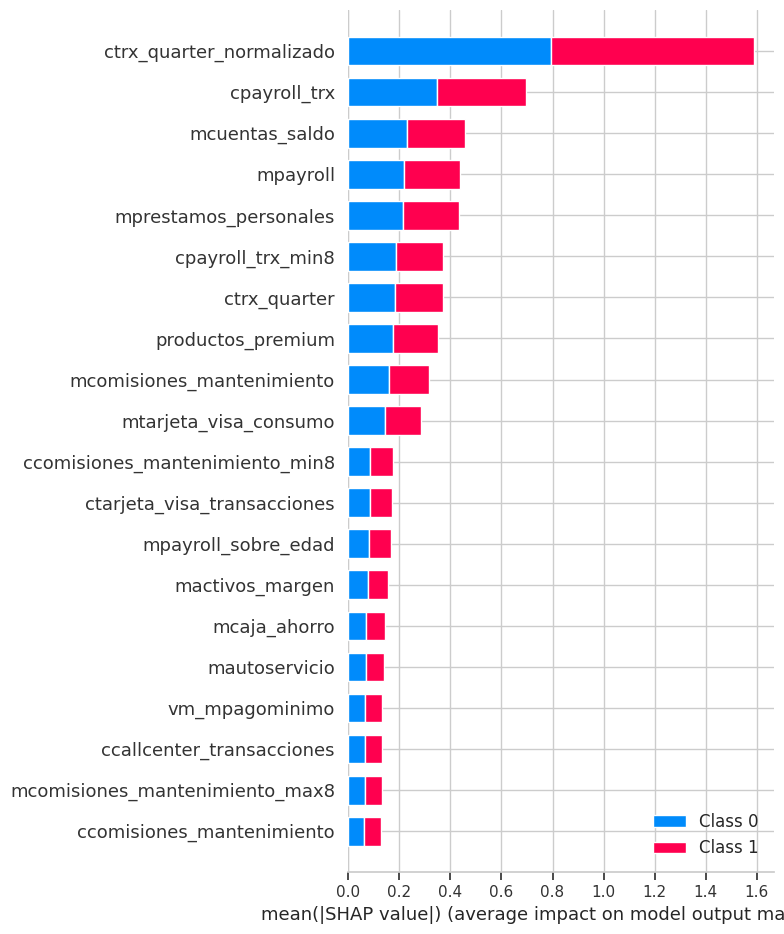

In [20]:
shap.summary_plot(shap_values, Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])])


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

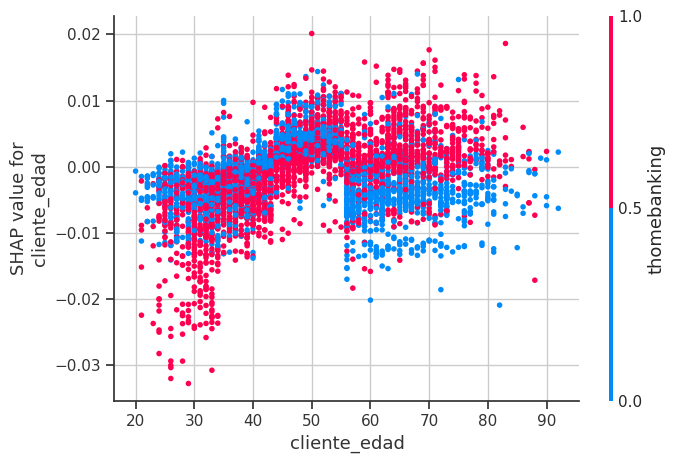

In [21]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])])

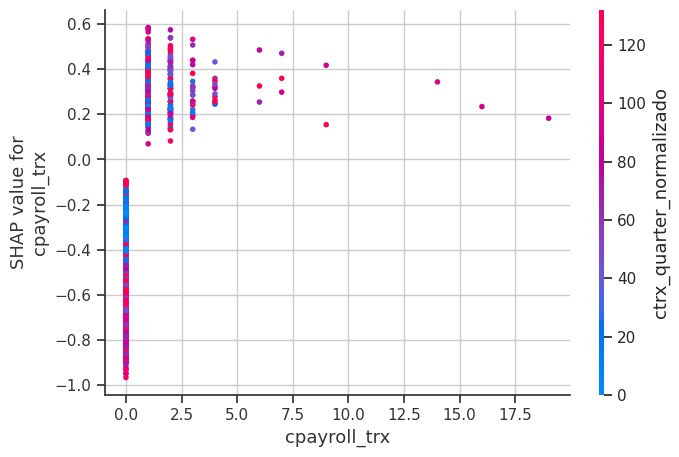

In [22]:
shap.dependence_plot("cpayroll_trx", shap_values[0], Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])])

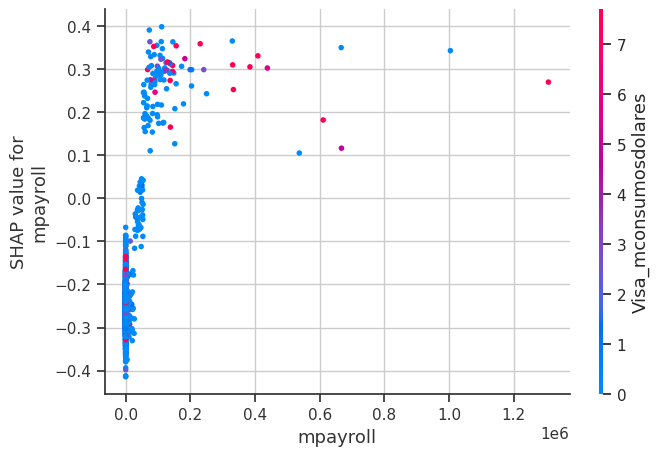

In [23]:
shap.dependence_plot("mpayroll", shap_values[0], Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])])

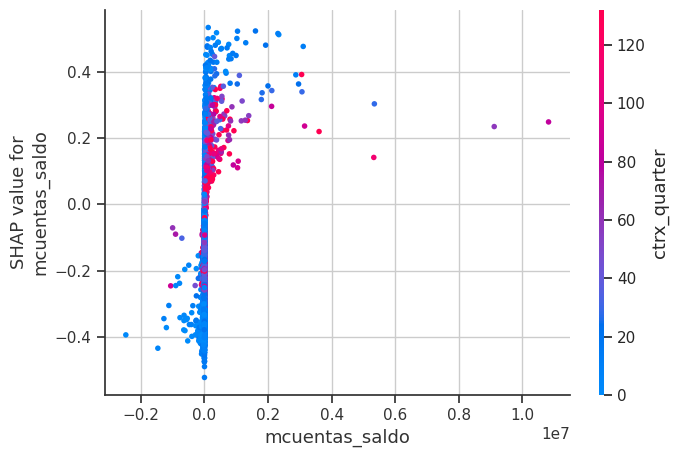

In [24]:
shap.dependence_plot("mcuentas_saldo", shap_values[0], Xbajas[Xbajas.columns.difference(['uso_app_bool', 'edad_split','renta_clase','edad_ag','foto_mes'])])

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

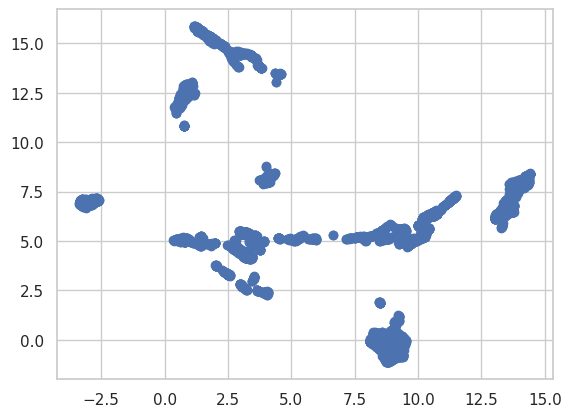

In [25]:
embedding_2d = UMAP(
  n_components=10, n_neighbors=40,random_state=539141
).fit_transform(shap_values[0],y=Xbajas['renta_clase'])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [26]:
embedding_2d = pd.DataFrame(embedding_2d)
embedding_2d = embedding_2d.add_prefix('umap_')
embedding_2d

,umap_0,umap_1,umap_2,umap_3,umap_4,umap_5,umap_6,umap_7,umap_8,umap_9
0,7.88,5.25,7.21,5.61,7.48,7.42,2.77,2.39,2.55,3.41
1,8.80,-0.45,7.16,5.30,9.83,5.48,-6.88,5.28,-0.64,8.89
2,1.56,15.45,-7.16,4.03,-0.40,9.88,5.11,1.52,4.74,2.85
3,10.59,6.31,10.86,4.21,6.25,8.48,2.92,1.04,2.17,5.63
4,2.04,3.75,5.12,2.18,5.36,7.64,2.89,0.77,3.31,3.95
...,...,...,...,...,...,...,...,...,...,...
5973,1.78,15.35,-6.72,3.92,-0.30,9.91,5.29,1.49,4.57,3.10
5974,13.84,7.95,16.80,4.77,4.64,5.67,-1.09,4.71,1.02,6.06
5975,0.99,12.54,5.81,4.20,1.70,11.45,6.66,7.76,-2.54,4.21
5976,1.22,15.83,-7.52,3.85,-0.41,9.63,5.02,1.64,5.06,2.77


In [27]:
Xbajas_umap = pd.concat([Xbajas.reset_index(),embedding_2d.reset_index()],axis=1)
Xbajas_umap.filter(regex='^umap_',axis=1)['umap_0'].shape

(5978,)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [48]:
labels = DBSCAN(eps=8.8).fit_predict(Xbajas_umap.filter(regex='^umap_',axis=1))
pd.Series(labels).value_counts()

0    3737
1    1288
2     649
3     304
dtype: int64

In [49]:
Xbajas_umap['cluster'] = labels

In [33]:

cols = [col for col in Xbajas_umap.columns if Xbajas_umap[col].isna().all().sum() == 0]
    
        

### ggpaires

In [126]:
Xbajas_umap_pair = Xbajas_umap
Xbajas_umap_pair['cluster'] = Xbajas_umap_pair.cluster.apply(lambda x: str(x))

In [130]:
Xbajas_umap_pair.cluster.describe()

count     6557
unique       4
top          0
freq      5209
Name: cluster, dtype: object

In [139]:
Xbajas_umap_pair[['cliente_edad','cliente_antiguedad','mrentabilidad','cpayroll_trx']]

,cliente_edad,cliente_antiguedad,mrentabilidad,cpayroll_trx
0,84,314,2102.692699,0
1,61,314,2628.804398,0
2,72,312,64.468855,0
3,60,153,530.882838,0
4,53,167,-693.733061,0
...,...,...,...,...
6552,46,8,-4518.424285,0
6553,73,6,127.409030,0
6554,31,3,126.030966,0
6555,66,2,0.000000,0


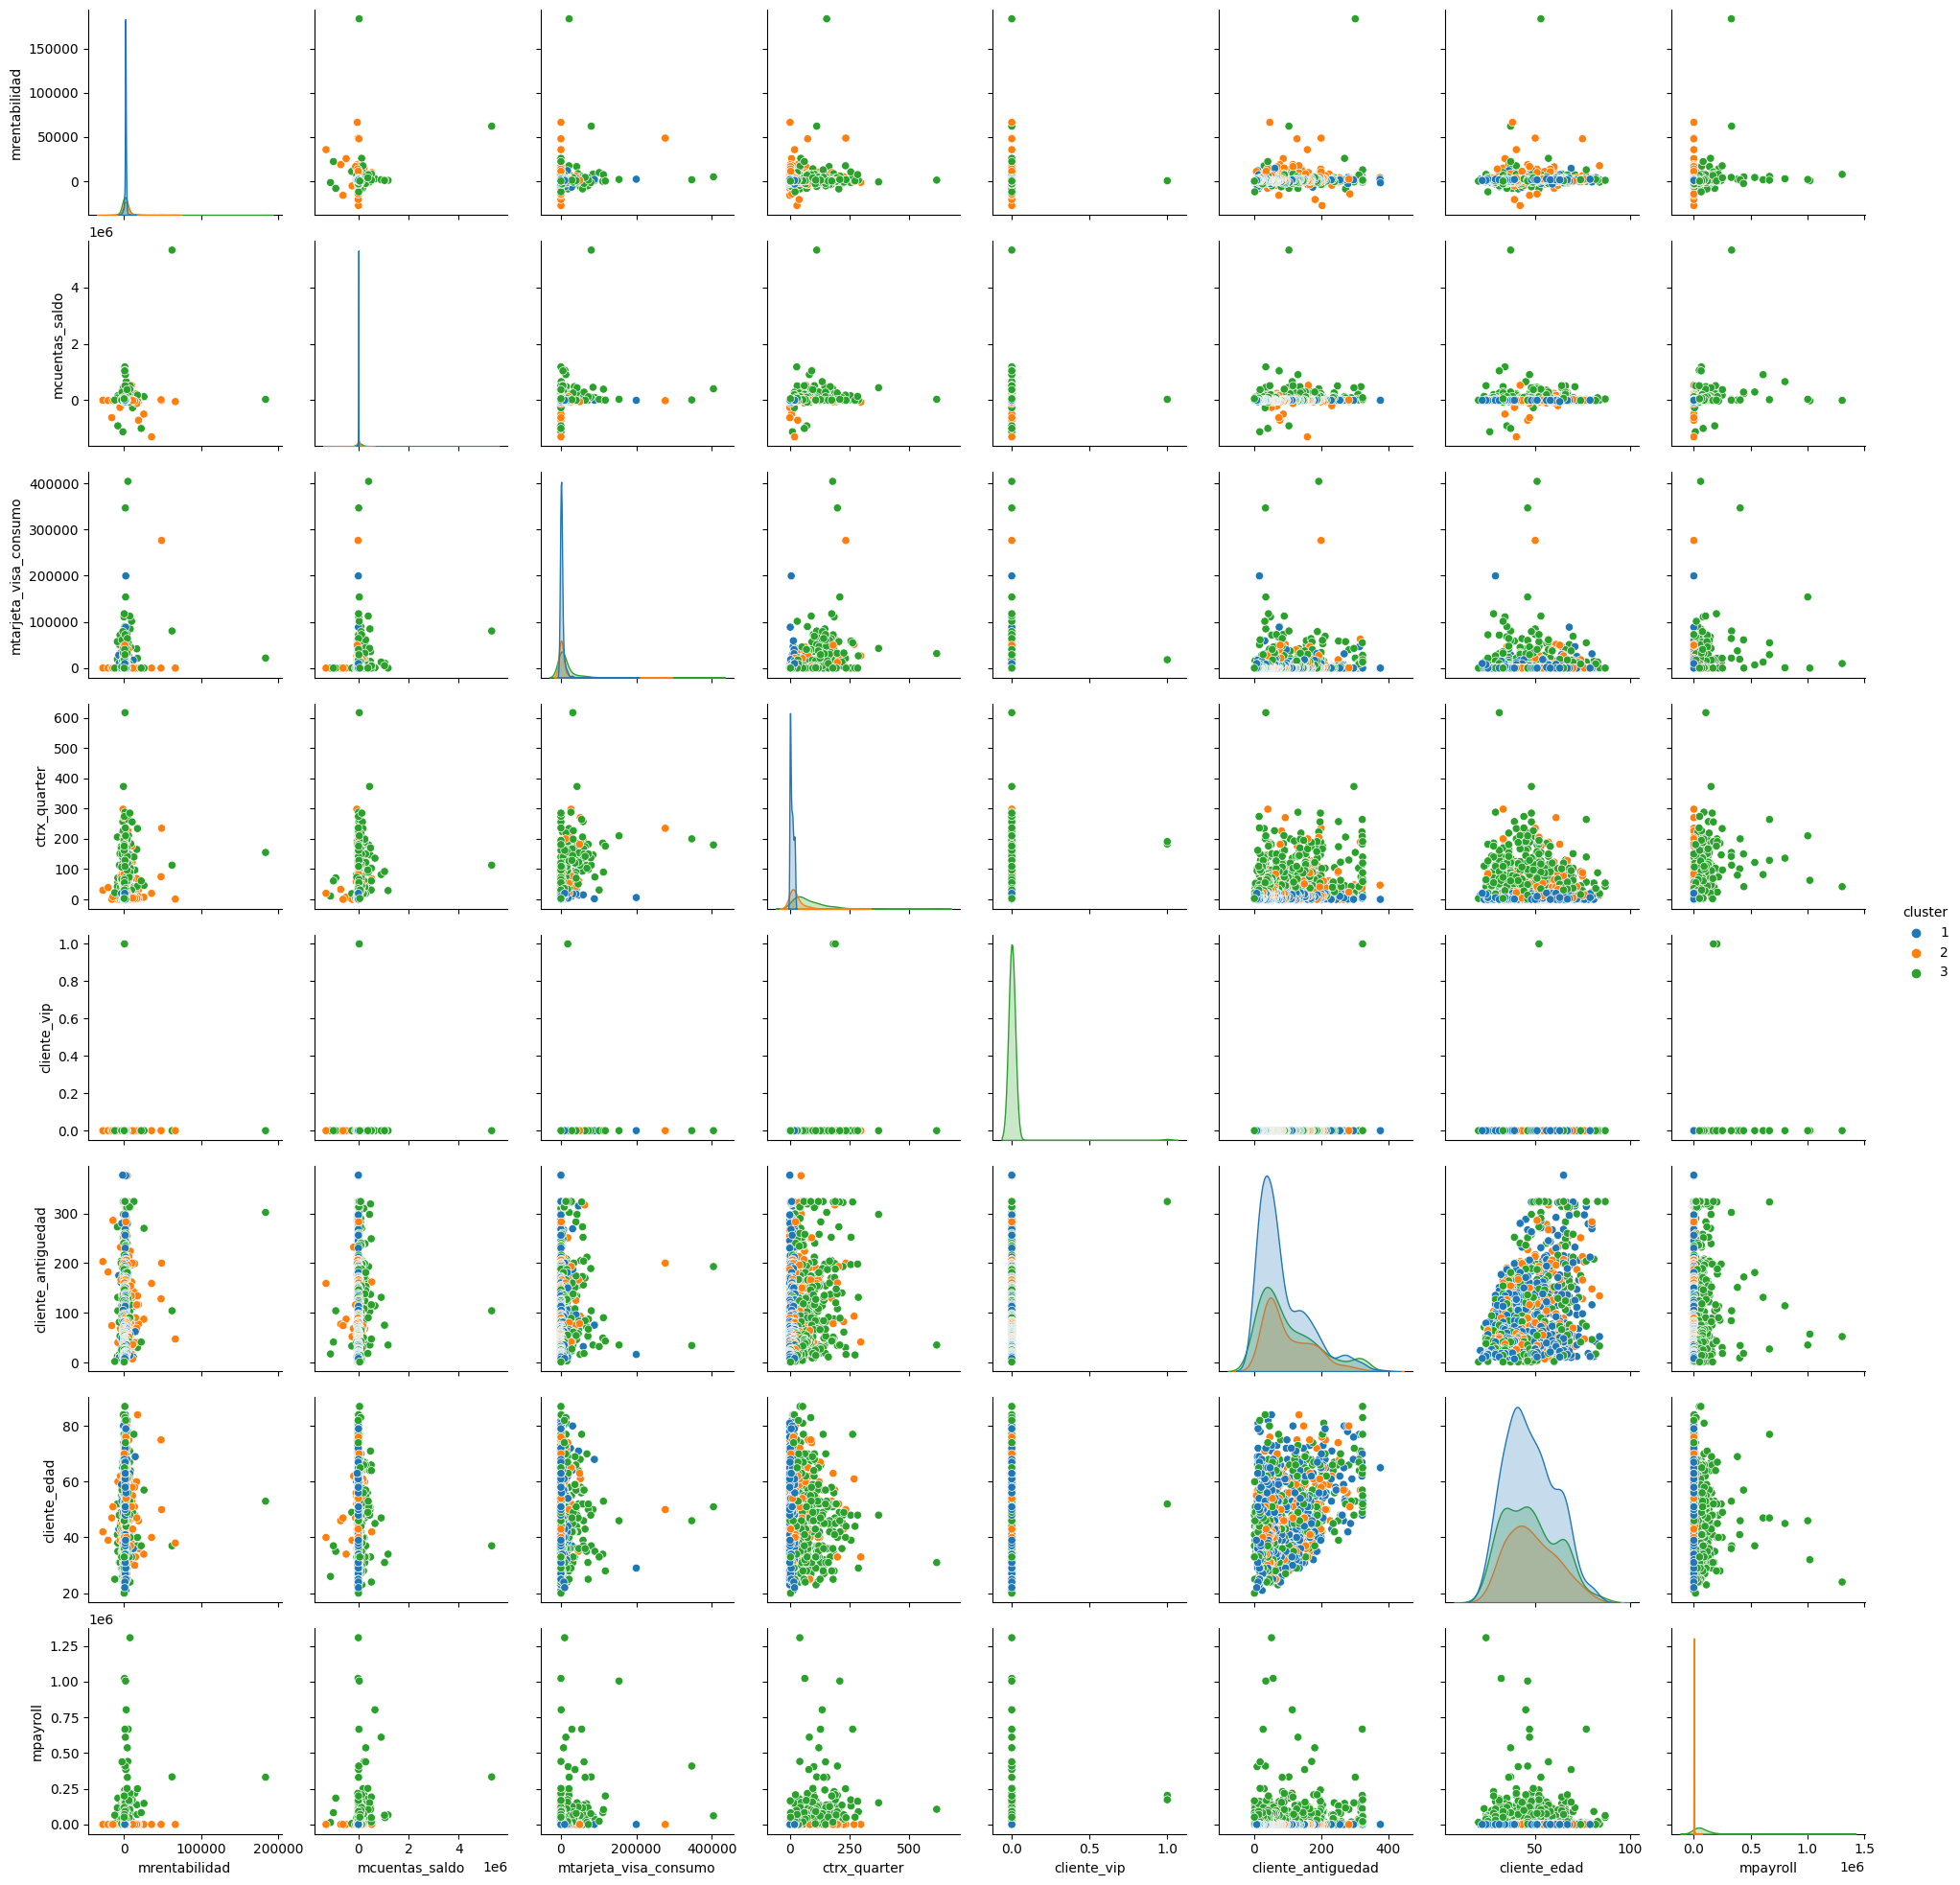

In [142]:
sns.pairplot(Xbajas_umap_pair.loc[Xbajas_umap_pair['cluster']!='0'][['mrentabilidad', 'mcuentas_saldo', 'mtarjeta_visa_consumo', 'ctrx_quarter', 'cliente_vip', 'cliente_antiguedad', 'cliente_edad', 'mpayroll','cluster']],hue='cluster')

In [120]:
g = sns.PairGrid(Xbajas_umap.all())
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

KeyError: True

In [33]:
Xbajas_umap.loc[Xbajas_umap['cluster']==3].mrentabilidad_annual.describe()

count                 343.00
mean              -10,588.61
std                17,629.35
min              -173,519.47
25%               -12,755.16
50%                -5,350.21
75%                -1,329.85
max                51,778.64
Name: mrentabilidad_annual, dtype: float64

In [34]:
Xbajas_umap.loc[Xbajas_umap['cluster']==2].mrentabilidad_annual.describe()

count                 594.00
mean               -4,888.80
std                10,815.45
min              -110,105.32
25%                -5,890.89
50%                -1,130.07
75%                    91.05
max                25,025.93
Name: mrentabilidad_annual, dtype: float64

In [35]:
Xbajas_umap.loc[Xbajas_umap['cluster']==1].mrentabilidad_annual.describe()

count               2,865.00
mean                8,390.93
std                 7,678.34
min               -54,736.90
25%                 4,102.91
50%                 7,248.18
75%                11,886.85
max               176,571.08
Name: mrentabilidad_annual, dtype: float64

In [36]:
Xbajas_umap.loc[Xbajas_umap['cluster']==0].mrentabilidad_annual.describe()

count               2,176.00
mean               35,799.27
std                77,763.54
min               -81,486.49
25%                14,073.01
50%                22,366.84
75%                34,346.91
max             2,339,247.18
Name: mrentabilidad_annual, dtype: float64

### sigue

In [50]:
scaler = StandardScaler()

In [51]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.mean})

,cpayroll_trx
cluster,
0,0.16
1,0.05
2,0.00
3,0.00


In [32]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx':np.max})

,cpayroll_trx
cluster,
0,19
1,4
2,1
3,1
4,0


In [33]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx_max8':np.mean})

,cpayroll_trx_max8
cluster,
0,0.49
1,0.11
2,0.51
3,0.51


In [34]:
Xbajas_umap.groupby('cluster').aggregate({'cpayroll_trx_max8':np.mean})

,cpayroll_trx_max8
cluster,
0,0.49
1,0.11
2,0.51
3,0.51


In [52]:
categories = ['ctrx_quarter_normalizado','cpayroll_trx','cpayroll_trx_max8','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','productos_premium','mrentabilidad_annual']
Xbajas_umap_cats = Xbajas_umap[categories+['cluster']]

In [53]:
Xbajas_umap_cats[categories] = scaler.fit_transform(Xbajas_umap_cats[categories])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### funcion radar qeu no funciona bien

In [49]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [50]:

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [125]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

### parte que sí

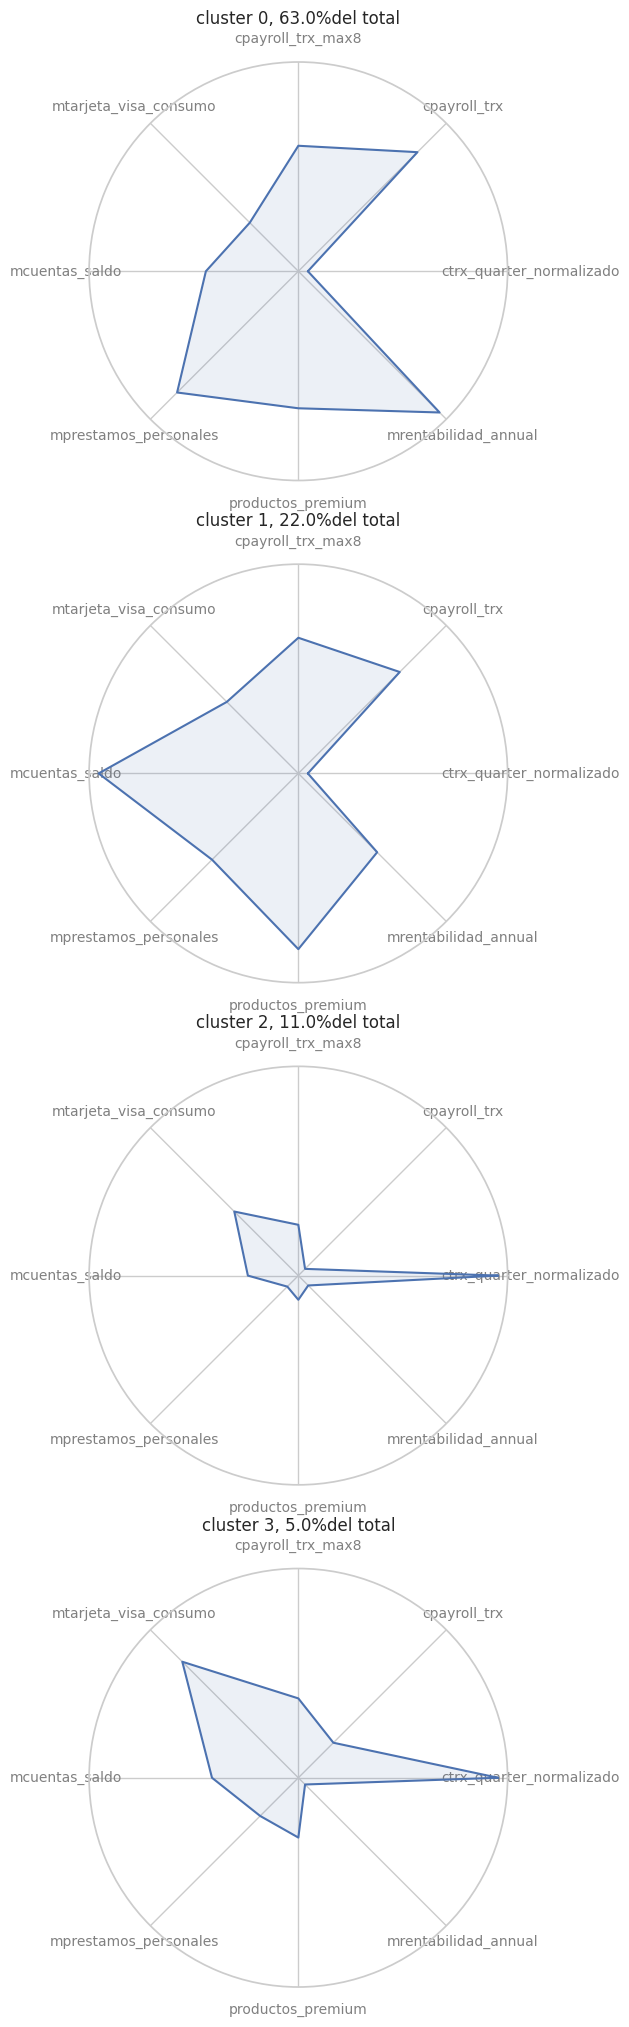

In [54]:

N = len(categories)

fig = plt.figure(figsize=(18,25))


#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for i,cl in zip([411,412,413,414],range(4)):
    ax = fig.add_subplot(i, polar=True)
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    #values

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    #theta = radar_factory(N, frame='polygon')
    #theta = np.linspace(0, 2*np.pi, N, endpoint=False)

    # Initialise the spider plot
    #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
    #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
    
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #ax.set_theta_offset(pi)
    prop = str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'
    ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
    #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

    plt.yticks([], [], color="grey", size=7)
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values)
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Show the graph
plt.show()

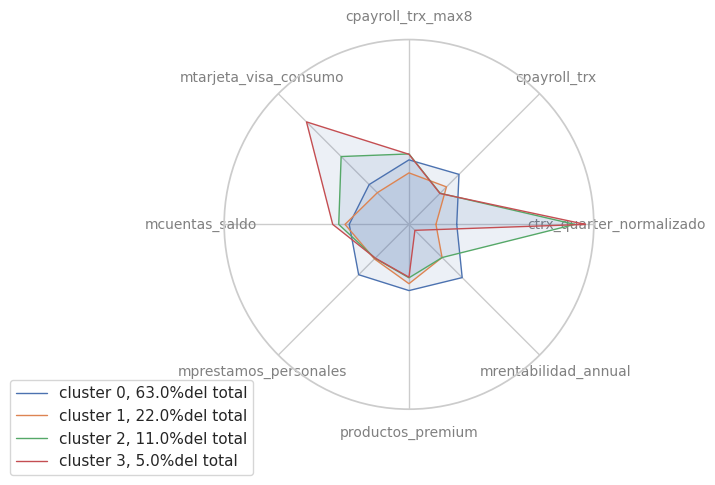

In [100]:
N = len(categories)

#fig = plt.figure(figsize=(18,18))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
plt.yticks([], [], color="grey", size=7)

#for i,j,cl in zip([0,0,1,1],[0,1,0,1],range(4)):
for cl in range(4):
    values = Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==cl].aggregate(np.mean).values.flatten().tolist()
    values += values[:1]
    values

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    #categories = ['ctrx_quarter','cpayroll_trx','mtarjeta_visa_consumo','mcuentas_saldo','mprestamos_personales','mpasivos_margen']
    #categories_relabeled = ['movimientos_trimestre', 'acred_haberes','consumos_tarjeta','saldo_en_cuentas','deuda_prestamos_personales','margen_por_pasivos']
    
    
    # Draw one axe per variable + add labels
    
    
    # Draw ylabels
    #ax.set_theta_offset(pi)
    prop = str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%'
    label = 'cluster '+ str(cl) + ', '+ prop + 'del total'
    #ax.set_title('cluster '+ str(cl) + ', '+ prop + 'del total')
    #ax.annotate(str(round(Xbajas_umap_cats.loc[Xbajas_umap_cats['cluster']==cl].shape[0]/Xbajas_umap_cats.shape[0] * 100,0))+'%',xy=(0.5,0.1),xycoords = 'subfigure fraction')

    
    #plt.ylim(0,40)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid',label=label)
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
gridlines = ax.yaxis.get_gridlines()
for gl in gridlines:
    gl.get_path()._interpolation_steps = N

    # Show the graph
plt.show()

### parte que no

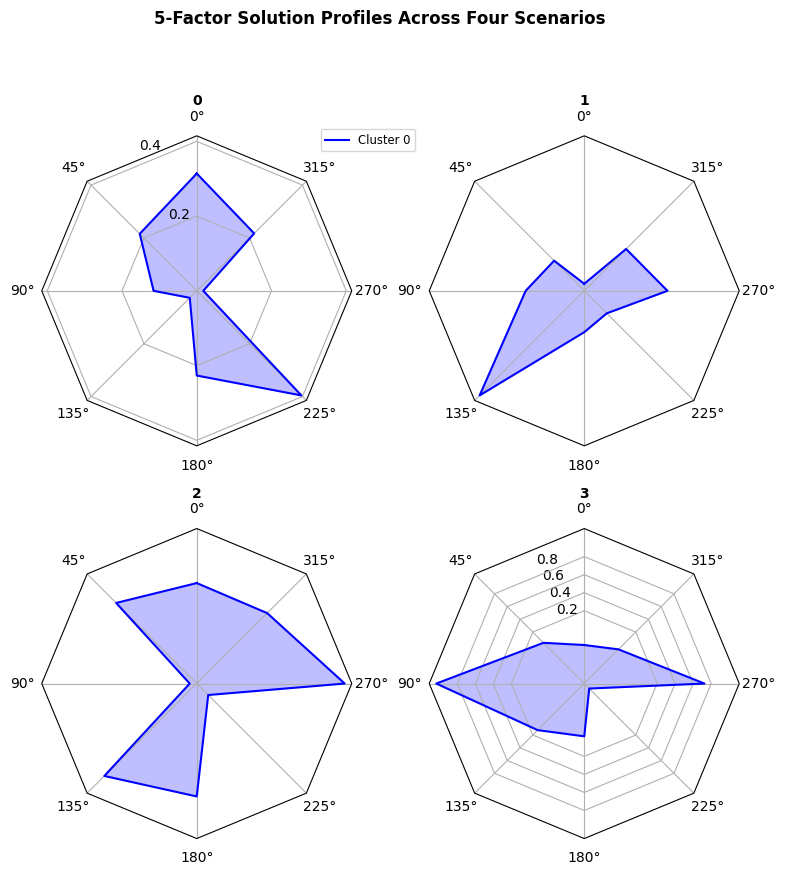

In [157]:
N = len(categories)
theta = radar_factory(N, frame='polygon')

data =arrange(Xbajas_umap_cats,4)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    #ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
labels = ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3')
legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
            horizontalalignment='center', color='black', weight='bold',
            size='large')

plt.show()

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (2).

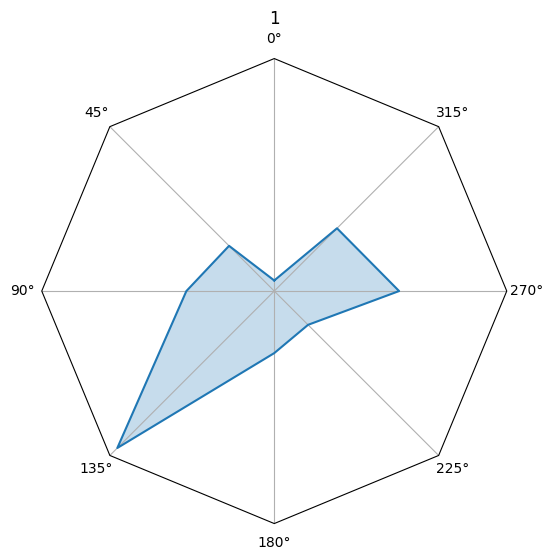

In [145]:
N = len(categories)
theta = radar_factory(N, frame='polygon')

data =arrange(Xbajas_umap_cats,4)
spoke_labels = data.pop(0)
title, case_data = data[0]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in case_data:
    line = ax.plot(theta, d)
    ax.fill(theta, d, alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)

plt.show()

In [144]:
Xbajas_umap_cats.groupby('cluster').aggregate(np.mean)

,ctrx_quarter_normalizado,cpayroll_trx,cpayroll_trx_max8,mtarjeta_visa_consumo,mcuentas_saldo,mprestamos_personales,productos_premium,mrentabilidad_annual
cluster,,,,,,,,
0,0.12,0.31,0.22,0.02,0.03,0.23,0.22,0.40
1,-0.12,-0.18,-0.14,-0.09,-0.02,-0.14,-0.12,-0.15
2,-0.44,-0.18,-0.14,-0.04,-0.09,-0.14,-0.18,-0.42
3,1.03,-0.18,0.03,0.73,0.12,-0.02,-0.07,-0.53


In [154]:
def arrange(df,n_clusters,categories=categories):
    lista = [categories]
    for i in range(n_clusters):
        lista.append((i,[list(pd.pivot_table(df, values=categories, index=['cluster'],
                  columns=[], aggfunc=np.mean).to_records()[i])[1:]]))
    return lista
         

In [155]:
arrange(Xbajas_umap_cats,4)

[['ctrx_quarter_normalizado',
  'cpayroll_trx',
  'cpayroll_trx_max8',
  'mtarjeta_visa_consumo',
  'mcuentas_saldo',
  'mprestamos_personales',
  'productos_premium',
  'mrentabilidad_annual'],
 (0,
  [[0.31383588062449214,
    0.2157964697936808,
    0.11552881391939394,
    0.02646427041652605,
    0.2266758774605131,
    0.395842648915515,
    0.017444758219881666,
    0.2173099672117174]]),
 (1,
  [[-0.17991025505513977,
    -0.1384494451475913,
    -0.11983528706057722,
    -0.015678238459481127,
    -0.13991103258915408,
    -0.15099638807206853,
    -0.09111898197114164,
    -0.11915582532299128]]),
 (2,
  [[-0.17770532582265633,
    -0.13952002521558854,
    -0.44187765014009667,
    -0.09228812090876608,
    -0.14258426812078787,
    -0.4159476492262746,
    -0.04347981920976851,
    -0.18016900504803599]]),
 (3,
  [[-0.18048697366548552,
    0.031330695497628756,
    1.033273243507785,
    0.12288934279842513,
    -0.022468063330618286,
    -0.5296677800970188,
    0.7257233

In [82]:
grupos = Xbajas_umap_cats.groupby('cluster').aggregate(np.mean)


In [108]:
def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data

In [109]:
data = example_data()

In [140]:
pd.pivot_table(Xbajas_umap_cats, values=categories, index=['cluster'],
                  columns=[], aggfunc=np.mean).to_records()

rec.array([(0,  0.31383588,  0.21579647,  0.11552881,  0.02646427,  0.22667588,  0.39584265,  0.01744476,  0.21730997),
           (1, -0.17991026, -0.13844945, -0.11983529, -0.01567824, -0.13991103, -0.15099639, -0.09111898, -0.11915583),
           (2, -0.17770533, -0.13952003, -0.44187765, -0.09228812, -0.14258427, -0.41594765, -0.04347982, -0.18016901),
           (3, -0.18048697,  0.0313307 ,  1.03327324,  0.12288934, -0.02246806, -0.52966778,  0.72572333, -0.07132554)],
          dtype=[('cluster', '<i8'), ('cpayroll_trx', '<f8'), ('cpayroll_trx_max8', '<f8'), ('ctrx_quarter_normalizado', '<f8'), ('mcuentas_saldo', '<f8'), ('mprestamos_personales', '<f8'), ('mrentabilidad_annual', '<f8'), ('mtarjeta_visa_consumo', '<f8'), ('productos_premium', '<f8')])

In [142]:
arrange(Xbajas_umap_cats,4)[0]

(0,
 [[0.31383588062449214,
   0.2157964697936808,
   0.11552881391939394,
   0.02646427041652605,
   0.2266758774605131,
   0.395842648915515,
   0.017444758219881666,
   0.2173099672117174]])

In [136]:
Xbajas_umap_cats[categories].loc[Xbajas_umap_cats['cluster']==0].aggregate(np.mean).values.flatten().tolist()

[0.11552881391939393,
 0.31383588062449214,
 0.2157964697936808,
 0.017444758219881673,
 0.026464270416526044,
 0.2266758774605131,
 0.21730996721171736,
 0.395842648915515]

In [110]:
data

[['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
 ('Basecase',
  [[0.88, 0.01, 0.03, 0.03, 0.0, 0.06, 0.01, 0.0, 0.0],
   [0.07, 0.95, 0.04, 0.05, 0.0, 0.02, 0.01, 0.0, 0.0],
   [0.01, 0.02, 0.85, 0.19, 0.05, 0.1, 0.0, 0.0, 0.0],
   [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.0, 0.0],
   [0.01, 0.01, 0.02, 0.71, 0.74, 0.7, 0.0, 0.0, 0.0]]),
 ('With CO',
  [[0.88, 0.02, 0.02, 0.02, 0.0, 0.05, 0.0, 0.05, 0.0],
   [0.08, 0.94, 0.04, 0.02, 0.0, 0.01, 0.12, 0.04, 0.0],
   [0.01, 0.01, 0.79, 0.1, 0.0, 0.05, 0.0, 0.31, 0.0],
   [0.0, 0.02, 0.03, 0.38, 0.31, 0.31, 0.0, 0.59, 0.0],
   [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.0, 0.0]]),
 ('With O3',
  [[0.89, 0.01, 0.07, 0.0, 0.0, 0.05, 0.0, 0.0, 0.03],
   [0.07, 0.95, 0.05, 0.04, 0.0, 0.02, 0.12, 0.0, 0.0],
   [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.0, 0.0, 0.0],
   [0.01, 0.03, 0.0, 0.32, 0.29, 0.27, 0.0, 0.0, 0.95],
   [0.02, 0.0, 0.03, 0.37, 0.56, 0.47, 0.87, 0.0, 0.0]]),
 ('CO & O3',
  [[0.87, 0.01, 0.08, 0.0, 0.0, 

In [111]:
spoke_labels = data.pop(0)

In [112]:
spoke_labels

['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3']

In [113]:
data

[('Basecase',
  [[0.88, 0.01, 0.03, 0.03, 0.0, 0.06, 0.01, 0.0, 0.0],
   [0.07, 0.95, 0.04, 0.05, 0.0, 0.02, 0.01, 0.0, 0.0],
   [0.01, 0.02, 0.85, 0.19, 0.05, 0.1, 0.0, 0.0, 0.0],
   [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.0, 0.0],
   [0.01, 0.01, 0.02, 0.71, 0.74, 0.7, 0.0, 0.0, 0.0]]),
 ('With CO',
  [[0.88, 0.02, 0.02, 0.02, 0.0, 0.05, 0.0, 0.05, 0.0],
   [0.08, 0.94, 0.04, 0.02, 0.0, 0.01, 0.12, 0.04, 0.0],
   [0.01, 0.01, 0.79, 0.1, 0.0, 0.05, 0.0, 0.31, 0.0],
   [0.0, 0.02, 0.03, 0.38, 0.31, 0.31, 0.0, 0.59, 0.0],
   [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.0, 0.0]]),
 ('With O3',
  [[0.89, 0.01, 0.07, 0.0, 0.0, 0.05, 0.0, 0.0, 0.03],
   [0.07, 0.95, 0.05, 0.04, 0.0, 0.02, 0.12, 0.0, 0.0],
   [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.0, 0.0, 0.0],
   [0.01, 0.03, 0.0, 0.32, 0.29, 0.27, 0.0, 0.0, 0.95],
   [0.02, 0.0, 0.03, 0.37, 0.56, 0.47, 0.87, 0.0, 0.0]]),
 ('CO & O3',
  [[0.87, 0.01, 0.08, 0.0, 0.0, 0.04, 0.0, 0.0, 0.01],
   [0.09, 0.95, 0.02, 0.03, 0.0, 0.01, 0.13, 0.

In [113]:
data

[-0.15027079334985613,
 -0.1718914253065137,
 -0.006255873208603256,
 -0.0951531809841252,
 -0.04332878381793303,
 -0.13877872840961963,
 -0.10062144448627436,
 -0.007539668009889929,
 -0.4883640021462054,
 -0.18048697366548552,
 -0.03356142691309866,
 -0.11086159810183142,
 -0.0996787025066583,
 -0.14197877984221735,
 -0.1805993914881781,
 -0.4052805309264601,
 0.6856766263013994,
 1.1217661936111065,
 0.12643921363621935,
 0.21558387476641885,
 0.2611634625784043,
 0.9074420236709525,
 0.7084258622780025,
 0.596268217840245,
 0.5636691550502249,
 -0.16181693051700485,
 -0.11009196181246295,
 0.5245969282210422,
 0.03483662807287006,
 -0.13628116929160378,
 -0.11205061896709229,
 -0.5060474860447164]

In [120]:
list(Xbajas_umap_cats.groupby('cluster'))

[(0,
        ctrx_quarter_normalizado         cpayroll_trx   cpayroll_trx_tend6  \
  0                        -0.60                -0.18                 0.13   
  1                        -0.52                -0.18                 0.13   
  5                        -0.58                -0.18                 0.13   
  6                        -0.64                -0.18                 0.13   
  7                        -0.70                -0.18                 0.13   
  ...                        ...                  ...                  ...   
  5964                     -0.70                -0.18                 0.13   
  5966                     -0.70                -0.18                 0.13   
  5967                     -0.58                -0.18                -3.65   
  5970                     -0.68                -0.18                 0.13   
  5974                     -0.70                -0.18                 0.13   
  
        mtarjeta_visa_consumo       mcuentas_saldo  mpre

### sigue

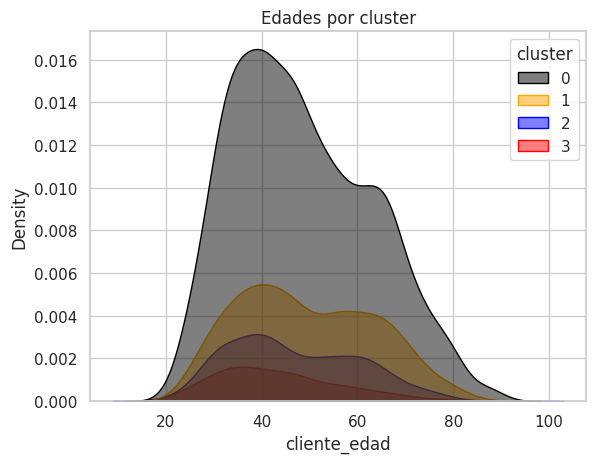

In [56]:
sns.kdeplot(data = Xbajas_umap, x='cliente_edad',hue='cluster',fill=True,alpha=0.5, palette = ['black','orange','blue','red'])

plt.title('Edades por cluster')
#plt.xlim(-200,10000)
plt.show()

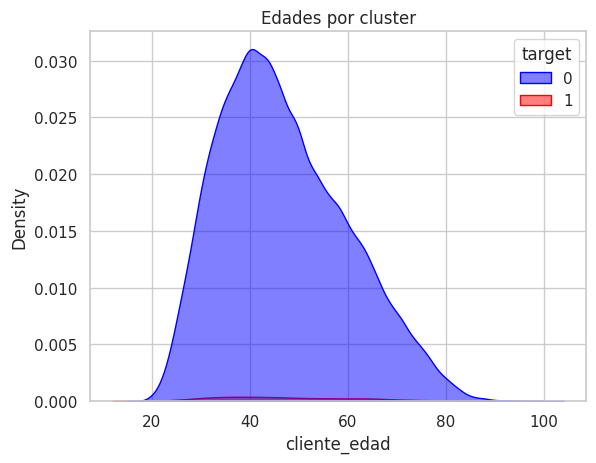

In [40]:
sns.kdeplot(data = df, x='cliente_edad',hue='target',fill=True,alpha=0.5, palette = ['blue','red'])

plt.title('Edades por cluster')
#plt.xlim(-200,10000)
plt.show()

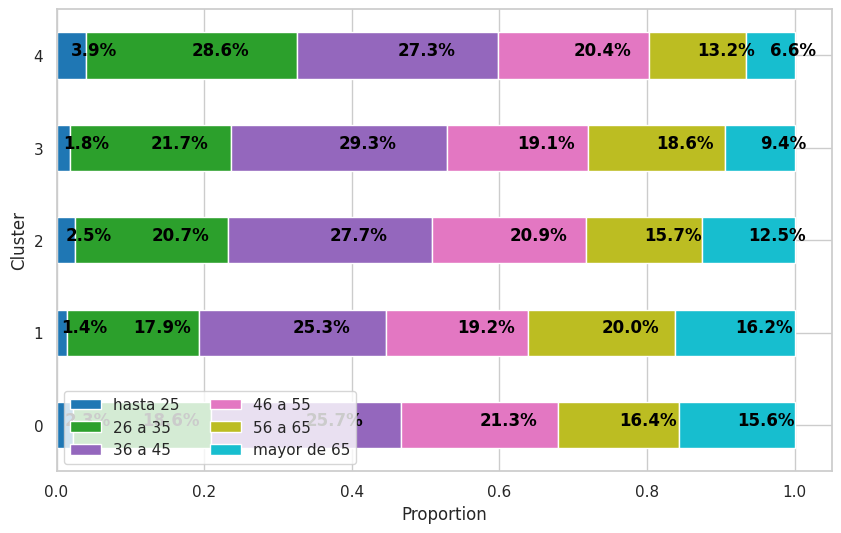

In [37]:
cross_tab_prop = pd.crosstab(index=Xbajas_umap['cluster'],
                             columns=Xbajas_umap['edad_ag'],
                             normalize="index")


cross_tab = pd.crosstab(index=Xbajas_umap['cluster'],
                        columns=Xbajas_umap['edad_ag'])

cross_tab_prop.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.ylabel("Cluster")
plt.xlabel("Proportion")



for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                          cross_tab.loc[x],
                                          cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
#ax.bar(cross_tab_prop.index, cross_tab_prop.columns, width=1, edgecolor='white')
plt.show()

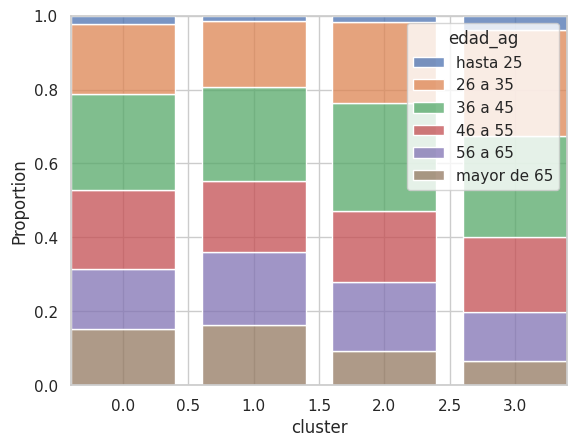

In [57]:
edades = ['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65']
ax = sns.histplot(
    data=Xbajas_umap,
    x="cluster", hue="edad_ag", hue_order=edades.reverse(),
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)


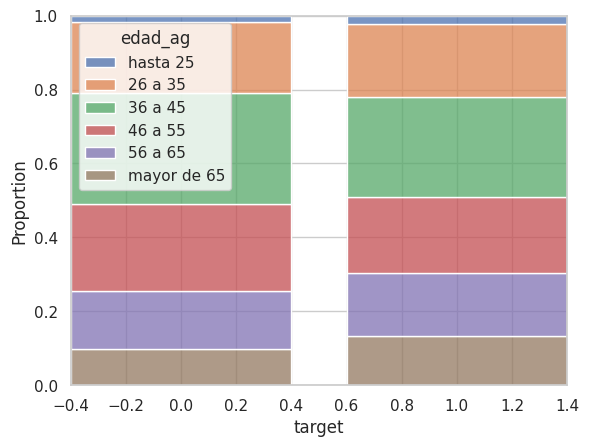

In [58]:
edades = ['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65']
ax = sns.histplot(
    data=df,
    x="target", hue="edad_ag", hue_order=edades.reverse(),
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

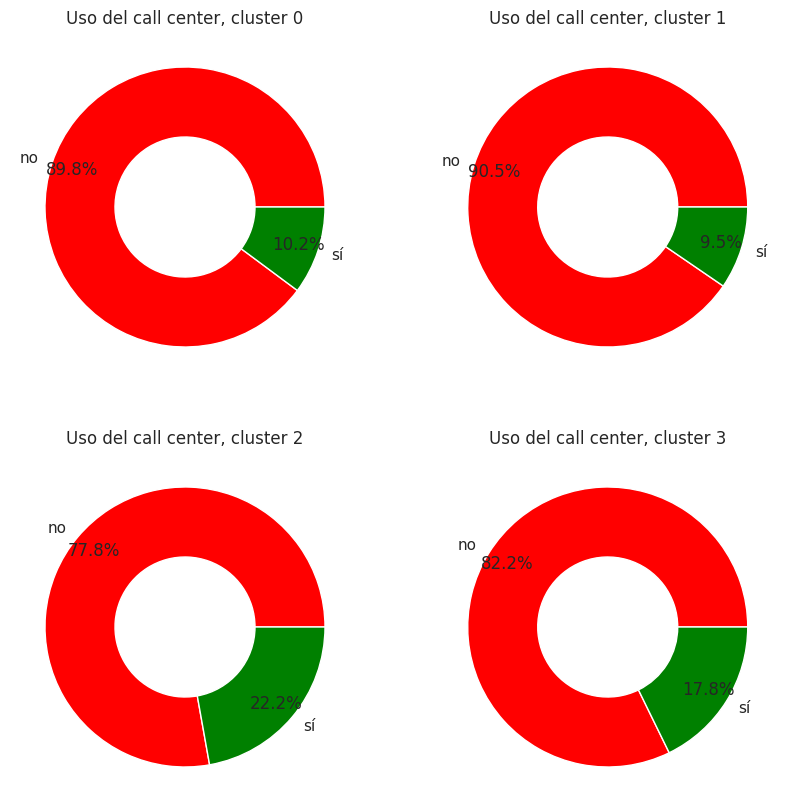

In [59]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(10,10))
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
for cl,j,k in zip(range(4),[0,0,1,1],[0,1,0,1]):

        ax[j,k].pie(Xbajas_umap[Xbajas_umap.cluster == cl]['tcallcenter'].value_counts(), colors=['red','green'], labels=['no','sí'],
                autopct='%1.1f%%', pctdistance=0.85,wedgeprops=dict(width=.5))
        #plt.gca().add_artist(centre_circle)
        ax[j,k].set_title(f'Uso del call center, cluster {cl}')
  
# Displaying Chart
plt.show()

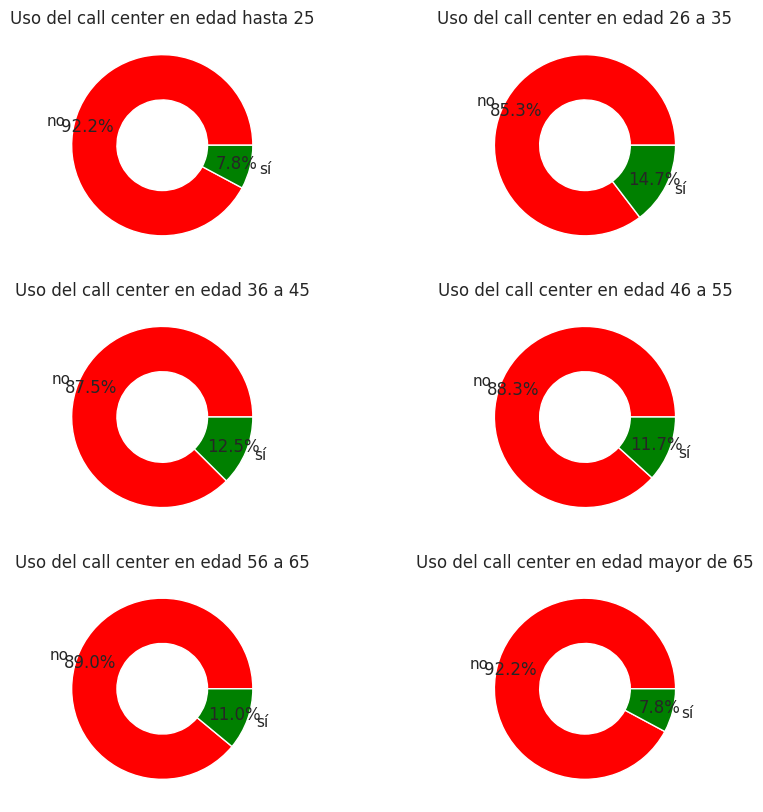

In [41]:
fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(10,10))
fig = plt.gcf()
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
for ea,j,k in zip(['hasta 25', '26 a 35','36 a 45', '46 a 55', '56 a 65','mayor de 65'],[0,0,1,1,2,2],[0,1,0,1,0,1]):

        ax[j,k].pie(Xbajas_umap[Xbajas_umap.edad_ag == ea]['tcallcenter'].value_counts(), colors=['red','green'], labels=['no','sí'],
                autopct='%1.1f%%', pctdistance=0.85,wedgeprops=dict(width=.5))
        #plt.gca().add_artist(centre_circle)
        ax[j,k].set_title(f'Uso del call center en edad {ea}')
  
# Displaying Chart
plt.show()

<AxesSubplot: xlabel='edad_ag', ylabel='Proportion'>

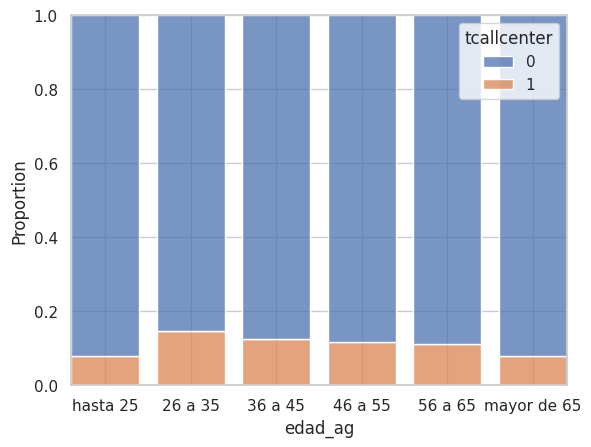

In [60]:
sns.histplot(
    data=Xbajas_umap,
    x="edad_ag", hue="tcallcenter",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

<AxesSubplot: xlabel='cluster', ylabel='Proportion'>

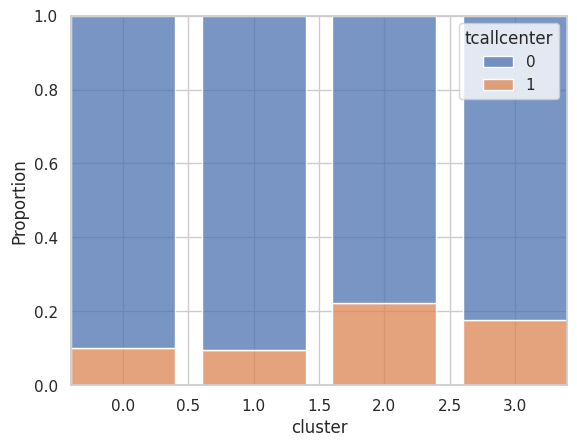

In [61]:
sns.histplot(
    data=Xbajas_umap,
    x="cluster", hue="tcallcenter",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

<AxesSubplot: xlabel='target', ylabel='Proportion'>

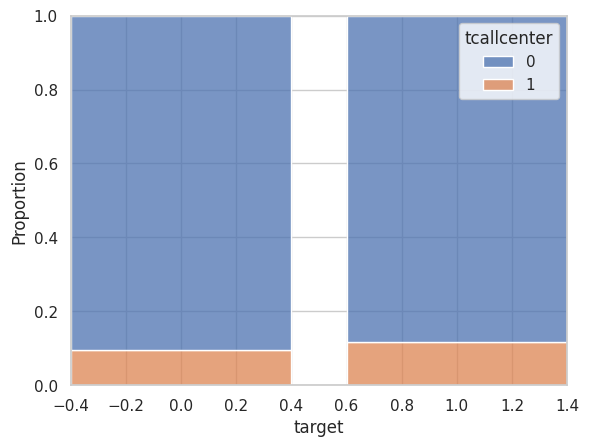

In [62]:
sns.histplot(
    data=df,
    x="target", hue="tcallcenter",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

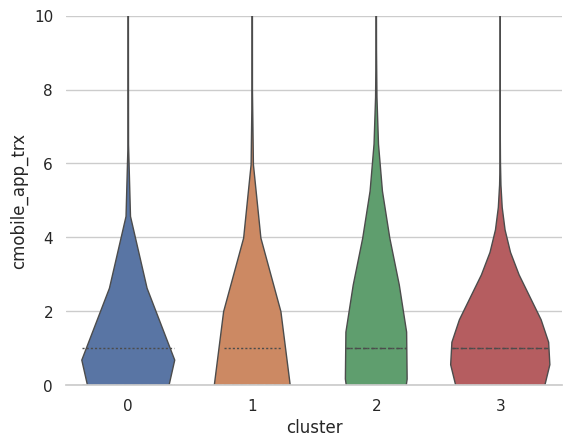

In [63]:

# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="cluster", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

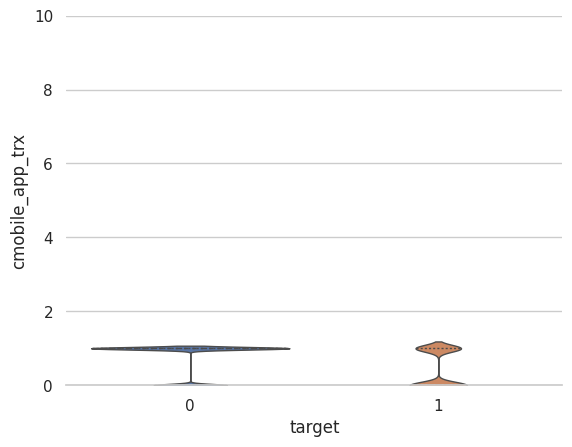

In [64]:
ax = sns.violinplot(data=df, x="target", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

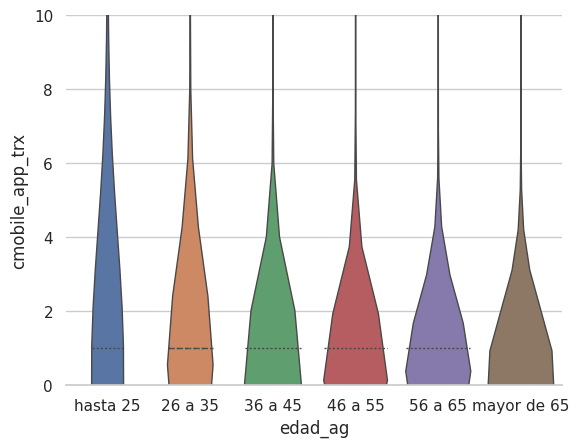

In [65]:
# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="edad_ag", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

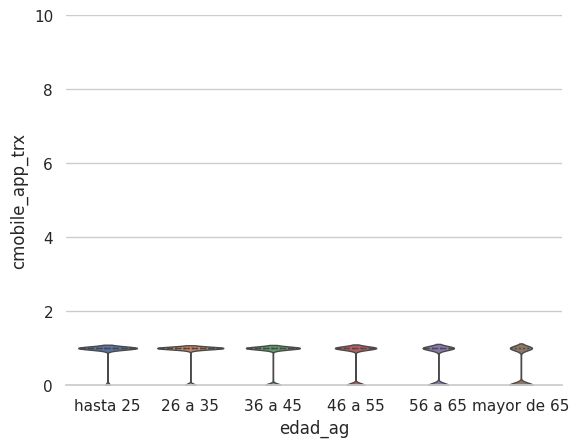

In [52]:
# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=df, x="edad_ag", y="cmobile_app_trx",
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

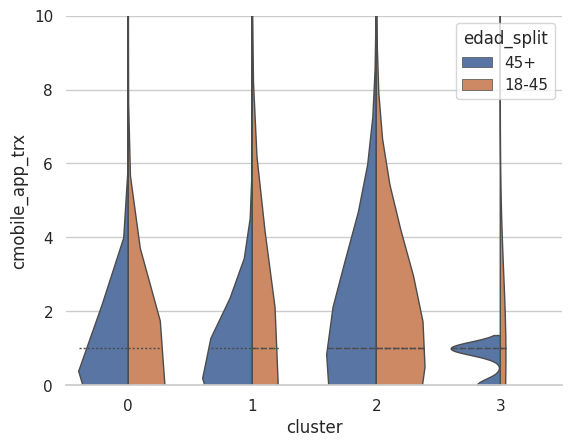

In [66]:

# Load the example tips dataset


# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=Xbajas_umap, x="cluster", y="cmobile_app_trx", split=True, hue='edad_split',
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

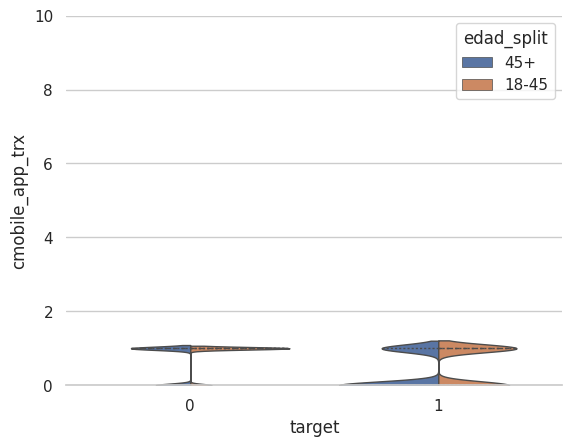

In [54]:
ax = sns.violinplot(data=df, x="target", y="cmobile_app_trx", split=True, hue='edad_split',
               inner="quart", linewidth=1
               #palette={"Yes": "b", "No": ".85"}
)
ax.set_ylim(ymax=10,ymin=0)
sns.despine(left=True)

In [55]:
for cl in range(4):
    prop = Xbajas_umap.query(f'cluster == {cl} & cmobile_app_trx >= 1').mrentabilidad.count() / Xbajas_umap.loc[Xbajas_umap.cluster == cl].mrentabilidad.count()
    print('cluster',cl,'prop',int(round(prop,2)*100),'%')

cluster 0 prop 42 %
cluster 1 prop 21 %
cluster 2 prop 71 %
cluster 3 prop 74 %


<AxesSubplot: xlabel='cluster', ylabel='Proportion'>

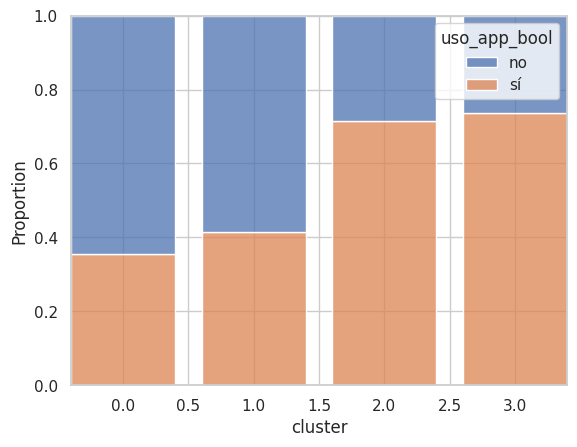

In [67]:
sns.histplot(
    data=Xbajas_umap,
    x="cluster", hue="uso_app_bool",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

<AxesSubplot: xlabel='target', ylabel='Proportion'>

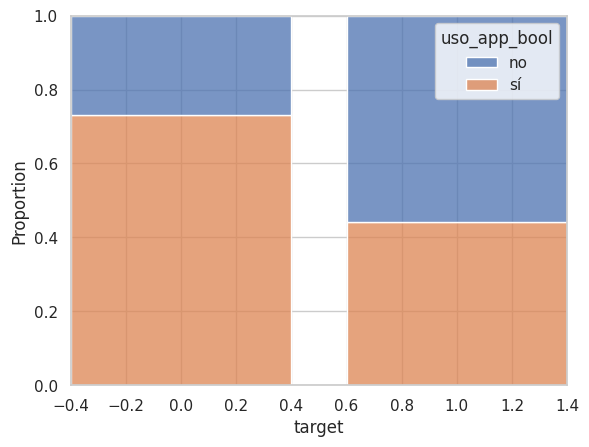

In [68]:
sns.histplot(
    data=df,
    x="target", hue="uso_app_bool",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

In [43]:
Xbajas_umap.mpayroll.describe()

count               5,978.00
mean                5,062.98
std                37,469.83
min                     0.00
25%                     0.00
50%                     0.00
75%                     0.00
max             1,306,994.02
Name: mpayroll, dtype: float64

In [ ]:
Xbajas_umap.loc[]

In [76]:
df_hab = df[['mpayroll','mpayroll_max8']]

In [77]:
df['perdio_haberes'] = df_hab.apply(lambda x: 1 if x['mpayroll']==0 and x['mpayroll_max8']>0 else 0,axis=1)
del df_hab

In [78]:
Xbajas_umap['perdio_haberes'] = Xbajas_umap.apply(lambda x: 1 if x['mpayroll']==0 and x['mpayroll_max8']>0 else 0,axis=1)

<AxesSubplot: xlabel='cluster', ylabel='Proportion'>

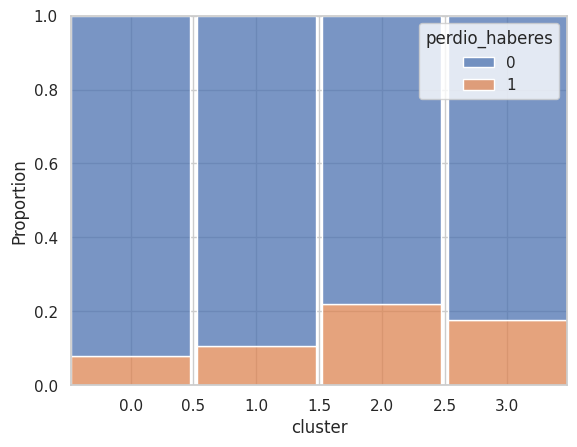

In [86]:
sns.histplot(
    data=Xbajas_umap,
    x="cluster", hue="perdio_haberes",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.95
)

<AxesSubplot: xlabel='target', ylabel='Proportion'>

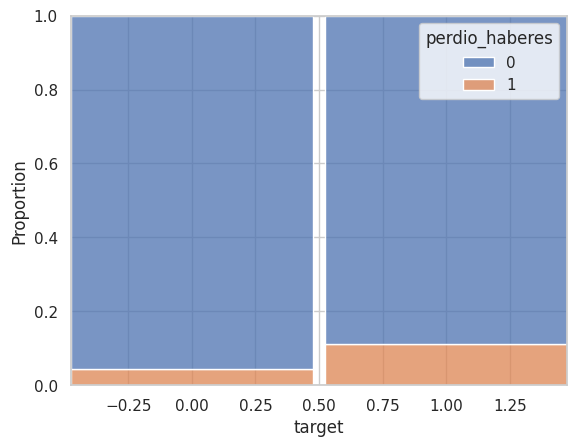

In [85]:
sns.histplot(
    data=df,
    x="target", hue="perdio_haberes",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.95
)

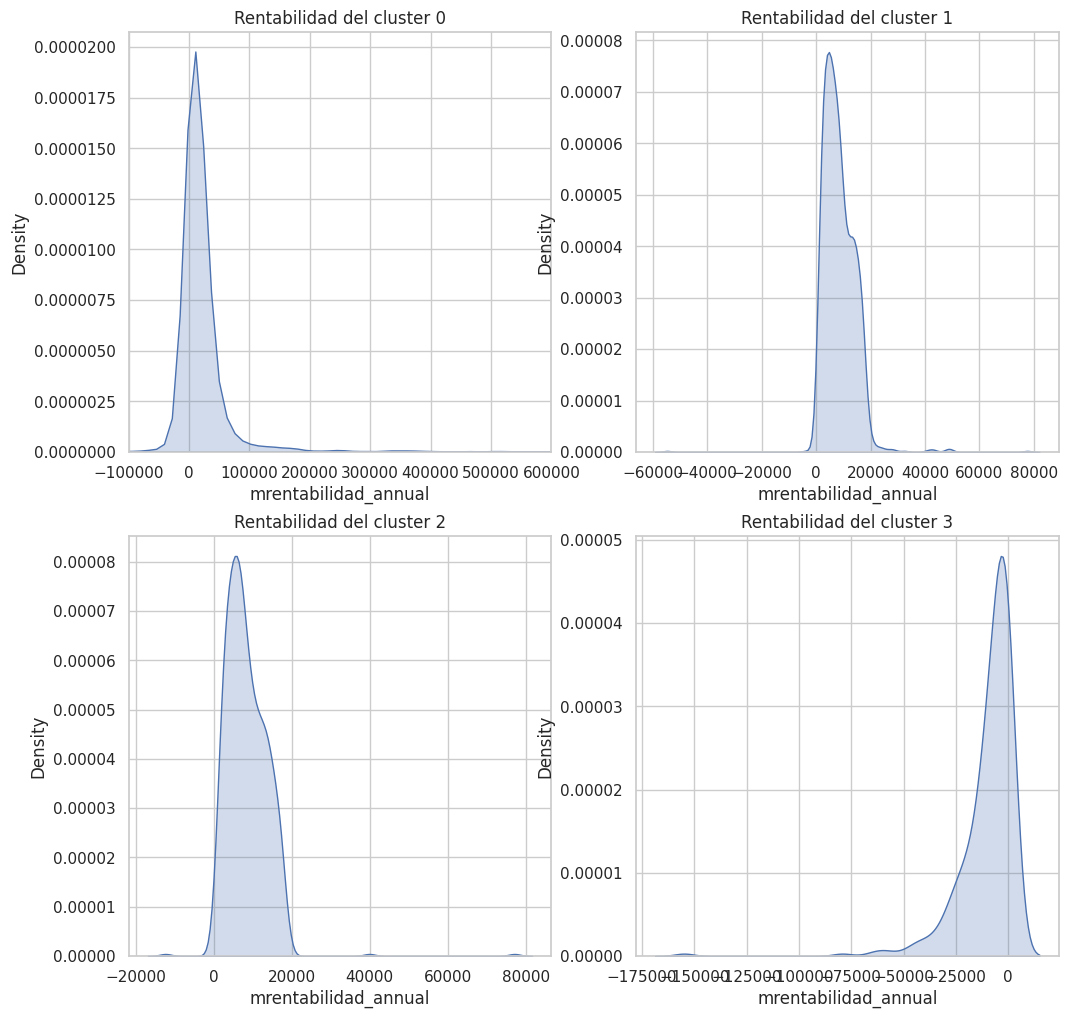

In [117]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(12,12))

for cl,i,j in zip(range(4),[0,0,1,1],[0,1,0,1]):
    ax[i,j] = sns.kdeplot(data = Xbajas_umap.loc[Xbajas_umap.cluster==cl], x='mrentabilidad_annual',fill=True, ax=ax[i,j])

    ax[i,j].set_title(f'Rentabilidad del cluster {cl}')
    ax[i,j].ticklabel_format(useOffset=False, style='plain')
    if cl == 0:
        ax[i,j].set_xlim(-100000,600000)
#sns.despine(left=True)


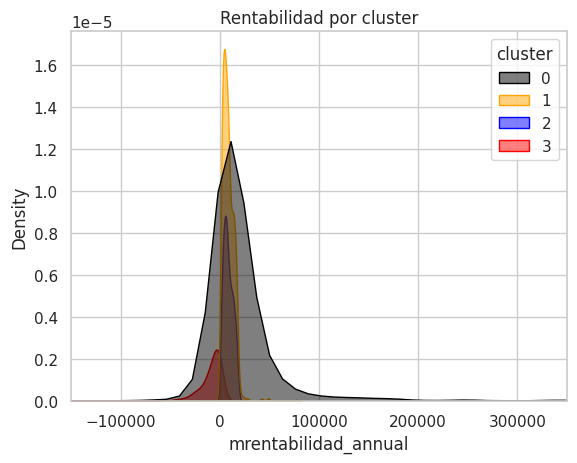

In [119]:
sns.kdeplot(data = Xbajas_umap, x='mrentabilidad_annual',hue='cluster',fill=True,alpha=0.5, palette = ['black','orange','blue','red'])

plt.title('Rentabilidad por cluster')
plt.xlim(-150000,350000)
plt.show()

In [110]:
Xbajas_umap.loc[Xbajas_umap.cluster == 0].mrentabilidad_annual.describe()

count               3,737.00
mean               22,001.15
std                62,152.45
min              -173,519.47
25%                 2,354.09
50%                12,767.63
75%                24,439.63
max             2,339,247.18
Name: mrentabilidad_annual, dtype: float64